In [1]:
import optuna
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

/Users/rafaeldks/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Конфиг с параметрами обучения

In [2]:
# Доступные функции потерь для минимизации моделью
loss_functions = {
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
}

In [3]:
# Задаём список из топ-5 лиг
top_5_leagues = ['Premier League', 'LaLiga', 'Serie A', 'Bundesliga', 'Ligue 1']

In [4]:
log_target = False  # True - применять логарифмирование таргета, False - не применять
top_five = False  # True - использовать данные только из ТОП-5 лиг, False - использоваться все доступные данные
loss_name = "mae"  # Название функции потерь для обучения (выбирается из списка loss_functions выше)
dataset_path = "final_dataset.xlsx" # Относительный или прямой путь к файлу с датасетом в формате .xlsx

### Чтение датасета для обучения модели

In [5]:
# Загружаем датасет из файла Excel в DataFrame pandas
df = pd.read_excel(dataset_path)

In [6]:
# Отбираем данные по топ-5 лигам при необходимости
if top_five:
    df = df[df['club_league'].isin(top_5_leagues)]

In [7]:
df.head()

,age,height,citizenship,player_agent,current_club,joined,outfitter,link,current_price,appearances,...,trophies_min_score,trophies_amount,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount,followers,position_group,position_role
0,22.0,1.85,Croatia,1,Manchester City,7,0,https://www.transfermarkt.com/josko-gvardiol/p...,80000000,68,...,4,27,303,37.875,81,8,9,1199636,defender,centre-back
1,29.0,1.80,Netherlands Cote d'Ivoire,1,Manchester City,43,1,https://www.transfermarkt.com/nathan-ake/profi...,40000000,75,...,4,27,303,37.875,81,8,9,2227475,defender,centre-back
2,23.0,1.71,Spain,1,Manchester City,18,0,https://www.transfermarkt.com/sergio-gomez/pro...,10000000,35,...,4,27,303,37.875,81,8,9,475430,defender,left-back
3,33.0,1.78,England,1,Manchester City,79,1,https://www.transfermarkt.com/kyle-walker/prof...,13000000,74,...,4,27,303,37.875,81,8,9,4911531,defender,right-back
4,25.0,1.83,Portugal Brazil,1,Manchester City,6,0,https://www.transfermarkt.com/matheus-nunes/pr...,55000000,65,...,4,27,303,37.875,81,8,9,447746,midfield,central midfield


In [8]:
print(f"Количество строк в датасете: {df.shape[0]}")
print(f"Количество столбцов в датасете: {df.shape[1]}")

Количество строк в датасете: 16140
Количество столбцов в датасете: 56


### Проверка значений в датасете на пропуски

In [9]:
assert df.isna().sum().sum() == 0
print("В датасете нет пропусков ✅ ")

В датасете нет пропусков ✅ 


### Выделение целевой переменной (таргета)

In [10]:
# Присваиваем значения из "current_price" новому столбцу "value"
df["value"] = df["current_price"]

# Удаляем столбцы "current_price" и "link"
df = df.drop(["current_price", "link"], axis=1)

In [11]:
# Выделяем признаки и таргет
X = df.drop(["value"], axis=1)
y = df["value"]

### Логарифмирование переменной

In [12]:
# Логарифмируем таргет при необходимости
if log_target:
    y = np.log1p(y)

In [13]:
# Выводим статистическую сводку по столбцу или Series "y"
y.describe()

count    1.614000e+04
mean     2.307404e+06
std      7.959596e+06
min      1.000000e+04
25%      1.250000e+05
50%      3.000000e+05
75%      9.500000e+05
max      1.800000e+08
Name: value, dtype: float64

### Распределение целевой переменной

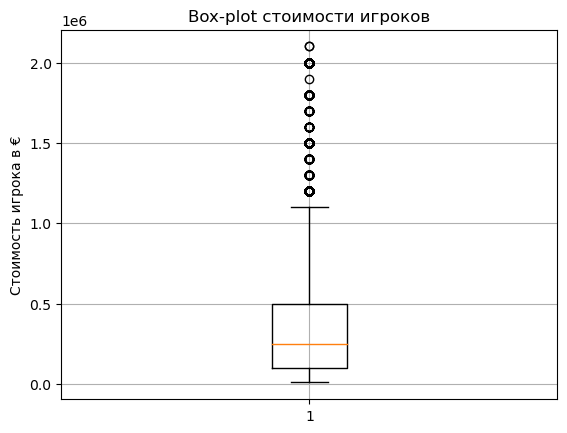

In [14]:
# Вычисляем первый (Q1) и третий (Q3) квартили данных
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
# Вычисляем межквартильный размах (IQR)
IQR = Q3 - Q1
# Отфильтровываем данные, удаляем аномалии
y_plot = y[~((y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR)))]

# Строим box-plot отфильтрованных данных
plt.boxplot(y_plot)
if log_target:
    plt.ylabel("Логарифмированная стоимость игрока в €")
else:
    plt.ylabel("Стоимость игрока в €")
plt.title("Box-plot стоимости игроков")
plt.grid(True)
plt.show()

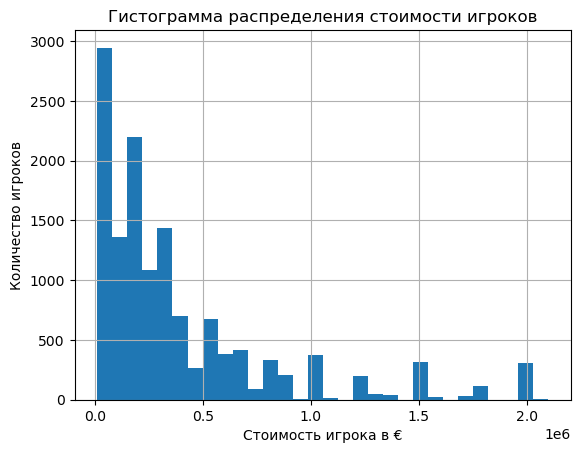

In [15]:
# Строим гистограмму распределения стоимости игроков
plt.hist(y_plot, bins=30)
if log_target:
    plt.xlabel("Логарифмированная стоимость игрока в €")
else:
    plt.xlabel("Стоимость игрока в €")
plt.ylabel("Количество игроков")
plt.title("Гистограмма распределения стоимости игроков")
plt.grid(True)
plt.show()

In [16]:
# Разбиваем данные на обучающий и тестовый датасеты
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [17]:
# Собираем все категориальные признаки из нашего датасета в список cat_features
cat_features = [col for col in X.columns if X[col].dtype == "object"]

In [18]:
# Создаем функцию для оптимизации параметров модели. Данная функция принимает на вход trial от Optuna и возвращает значение метрики (RMSE) на тестовой выборке.
def objective(trial: Trial):
    # Задаем пространство параметров для оптимизации
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "random_strength": trial.suggest_float("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 100.00),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100, log=True),
        "border_count": trial.suggest_int("border_count", 1, 10),
    }
    # Создаем модель CatBoostRegressor с данными параметрами
    model = CatBoostRegressor(**params)
    model.fit(
        # Обучаем модель на тренировочных данных
        X_train,
        y_train,
        # Обозначаем датасет для проверки при обучении
        eval_set=[(X_test, y_test)],
        # Подавляем вывод информации о процессе обучения кэтбустом
        verbose=0,
        # Указываем количество ранних остановок
        early_stopping_rounds=100,
        # Указываем индексы категориальных признаков
        cat_features=cat_features,
    )

    # Предсказываем значения стоимости игроков на тестовых данных
    y_preds = model.predict(X_test)
    # Вычисляем значение метрики RMSE (корень из среднеквадратической ошибки)
    loss = loss_functions[loss_name](y_test, y_preds)

    return loss

In [19]:
# Создаем study и запускаем Optuna на минимизацию метрики
study = optuna.create_study(direction="minimize")
# Начинаем процесс оптимизации
study.optimize(objective, n_trials=100)

[I 2024-03-18 18:47:15,056] A new study created in memory with name: no-name-f144db09-da2d-4c4c-b656-ea0212e9cc7c
[I 2024-03-18 18:47:18,477] Trial 0 finished with value: 1569329.7583713138 and parameters: {'iterations': 591, 'depth': 6, 'learning_rate': 0.04083577733840589, 'random_strength': 85.41730542829943, 'bagging_temperature': 75.81070252586068, 'od_wait': 41, 'l2_leaf_reg': 1.8332252649458515e-08, 'border_count': 1}. Best is trial 0 with value: 1569329.7583713138.
[I 2024-03-18 18:47:30,962] Trial 1 finished with value: 1137905.1480270445 and parameters: {'iterations': 673, 'depth': 10, 'learning_rate': 0.07562206296459235, 'random_strength': 19.93808827620124, 'bagging_temperature': 77.89593499720864, 'od_wait': 32, 'l2_leaf_reg': 0.0001413715836253114, 'border_count': 5}. Best is trial 1 with value: 1137905.1480270445.
[I 2024-03-18 18:47:36,179] Trial 2 finished with value: 1327619.9461168884 and parameters: {'iterations': 314, 'depth': 10, 'learning_rate': 0.04102643169539

### Наилучшие гиперпараметры обучения модели

In [20]:
# Итерируем по наилучшим параметрам, полученным с помощью оптимизации Optuna,
# и выводим их на экран
for key, value in study.best_params.items():
    print(f"{key}: {value}")

iterations: 872
depth: 9
learning_rate: 0.048731790095607394
random_strength: 0.27561606478441725
bagging_temperature: 36.51766583535168
od_wait: 13
l2_leaf_reg: 0.6506775240024947
border_count: 10


### Обучение итоговой модели

In [21]:
# Инициализируем модель
model = CatBoostRegressor(**study.best_params)

# Обучаем модель
model.fit(X_train, y_train, cat_features=cat_features)

0:	learn: 7746898.6791397	total: 15.8ms	remaining: 13.7s
1:	learn: 7491053.5761015	total: 29.9ms	remaining: 13s
2:	learn: 7242956.5236063	total: 47.1ms	remaining: 13.6s
3:	learn: 7007361.4510042	total: 65.4ms	remaining: 14.2s
4:	learn: 6787757.1663169	total: 81.2ms	remaining: 14.1s
5:	learn: 6567843.1649212	total: 95.1ms	remaining: 13.7s
6:	learn: 6365312.7259022	total: 112ms	remaining: 13.8s
7:	learn: 6176498.5848780	total: 132ms	remaining: 14.2s
8:	learn: 5992410.7397065	total: 146ms	remaining: 14s
9:	learn: 5820317.7165853	total: 161ms	remaining: 13.9s
10:	learn: 5652642.7777902	total: 178ms	remaining: 13.9s
11:	learn: 5487754.9388252	total: 194ms	remaining: 13.9s
12:	learn: 5332785.2463656	total: 211ms	remaining: 13.9s
13:	learn: 5192796.8234178	total: 227ms	remaining: 13.9s
14:	learn: 5049398.7301332	total: 241ms	remaining: 13.7s
15:	learn: 4910744.5410794	total: 257ms	remaining: 13.7s
16:	learn: 4779838.9628621	total: 272ms	remaining: 13.7s
17:	learn: 4651994.8532139	total: 288ms

### Оценка качества модели

In [22]:
# Получаем предсказания модели на тестовых данных
predictions = model.predict(X_test)

# Возвращаем таргет к нужному формату при необходимости
if log_target:
    predictions = np.expm1(predictions)
    y_test = np.expm1(y_test)
predictions = np.round(predictions)

In [23]:
example = pd.DataFrame()
# Построим отдельные столбцы для y_test и предсказаний
example["Факт"] = list(y_test[:5])
example["Прогноз"] = list(predictions[:5])
# Вычислим модуль разности ошибки
example["Модуль ошибки"] = abs(example["Факт"] - example["Прогноз"])
example.head()

,Факт,Прогноз,Модуль ошибки
0,300000,364293.0,64293.0
1,225000,145538.0,79462.0
2,650000,225745.0,424255.0
3,100000,297484.0,197484.0
4,500000,2673232.0,2173232.0


In [24]:
# Вычисляем среднеквадратическую ошибку (MSE)
mse = mean_squared_error(y_test, predictions)
# Извлекаем квадратный корень из MSE, чтобы получить RMSE
print("RMSE:", mse**0.5)

# Вычисляем среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(y_test, predictions)
print("MAE:", mae)

# Вычисляем коэффициент детерминации (R^2)
r2 = r2_score(y_test, predictions)
print("R^2:", r2)

# Вычисляем медианную абсолютную ошибку
medae = median_absolute_error(y_test, predictions)
print("Median Absolute Error:", medae)

# Вычисляем explained variance score
evs = explained_variance_score(y_test, predictions)
print("Explained Variance Score:", evs)

# Вычисляем среднюю абсолютную процентную ошибку (MAPE)
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Percentage Error:", mape)

RMSE: 3309691.0488834605
MAE: 975082.675030979
R^2: 0.8172844647690566
Median Absolute Error: 155098.0
Explained Variance Score: 0.817358268782099
Mean Absolute Percentage Error: 1.0886145035615709


### Обучение модели на всех имеющихся данных

In [25]:
model.fit(X, y, cat_features=cat_features)

0:	learn: 7682474.6511034	total: 20.3ms	remaining: 17.7s
1:	learn: 7420125.2967879	total: 38.7ms	remaining: 16.8s
2:	learn: 7172148.3206616	total: 55.9ms	remaining: 16.2s
3:	learn: 6936366.9283231	total: 72ms	remaining: 15.6s
4:	learn: 6721090.1654458	total: 88.5ms	remaining: 15.3s
5:	learn: 6507105.1108045	total: 106ms	remaining: 15.3s
6:	learn: 6306830.2856474	total: 123ms	remaining: 15.3s
7:	learn: 6118586.2074115	total: 140ms	remaining: 15.1s
8:	learn: 5935995.3635059	total: 157ms	remaining: 15s
9:	learn: 5764372.4701249	total: 172ms	remaining: 14.9s
10:	learn: 5602945.7670738	total: 188ms	remaining: 14.8s
11:	learn: 5451414.2918123	total: 203ms	remaining: 14.6s
12:	learn: 5304161.5169035	total: 219ms	remaining: 14.4s
13:	learn: 5162955.4449414	total: 237ms	remaining: 14.5s
14:	learn: 5032864.3544633	total: 253ms	remaining: 14.5s
15:	learn: 4906884.6702064	total: 271ms	remaining: 14.5s
16:	learn: 4781640.6610733	total: 289ms	remaining: 14.5s
17:	learn: 4668804.1321422	total: 304ms	

### Сохранение модели

In [26]:
# Сохраняем обученную модель в файл "best_model.cbm" для последующего использования
model.save_model("best_model.cbm")